## Segment DAPI channel - batch process a folder of images 

In [1]:
from skimage.io import imread
import pyclesperanto_prototype as cle  # version 0.24.3
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.8
from skimage import morphology
from skimage.morphology import disk, binary_erosion
import napari
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import tifffile as tif

In [2]:
# create napari viewer instance
if 'viewer' not in globals():
    viewer = napari.Viewer()

path = "/Users/laura/projects/Bio-image_analysis_school_ScadsAI/prepared_dataset"
prepared_images = os.listdir(path)
prepared_images

['aphidicolin_timelapse.tif',
 '.DS_Store',
 'nocodazole_timelapse.tif',
 'AZ-I_timelapse.tif',
 'taxol_timelapse.tif',
 'labels_nuclei',
 'latrunculin B_timelapse.tif',
 'epothilone B_timelapse.tif',
 'monastrol_timelapse.tif',
 'AZ-H_timelapse.tif',
 'DMSO_timelapse.tif',
 'colchicine_timelapse.tif',
 'doxorubicin_timelapse.tif',
 'cytochalasin B_timelapse.tif',
 'labels_tubulin',
 'labels_actin',
 'AZ-A_timelapse.tif']

### Process one image as an example

In [3]:
filename = 'latrunculin B_timelapse'

In [4]:
img = tif.imread(os.path.join(path, f'{filename}.tif'))

In [5]:
# viewer.add_image(img) # and then in the viewer right click on the layer - split RGB or:
viewer.add_image(
    img, 
    name=["tubulin", "actin", "nuclei"],
    colormap=["magenta", "green", "blue"],
    channel_axis=3)

[<Image layer 'tubulin' at 0x16e581670>,
 <Image layer 'actin' at 0x16e5816a0>,
 <Image layer 'nuclei' at 0x176ebfc40>]

In [6]:
image = viewer.layers['nuclei'].data
labels = []

for t in tqdm(range(image.shape[0])):

    # gaussian blur
    blurred_image = cle.gaussian_blur(image[t], None, 2.0, 2.0, 0.0)
    
    bg_removed = cle.top_hat_sphere(blurred_image, None, 20.0, 20.0, 0.0)

    # threshold otsu
    binary_nuclei = cle.threshold_otsu(bg_removed)

    # split touching objects
    binary_nuclei_edited = nsbatwm.split_touching_objects(binary_nuclei, 4.0)
    # additional erosion to split a few still touching nuclei
    binary_eroded_nuclei = binary_erosion(binary_nuclei_edited, disk(2))

    # connected component labeling
    labelled_nuclei = nsbatwm.connected_component_labeling(binary_eroded_nuclei, False)
    
    # expand eroded nuclei back
    dilated_labels = morphology.dilation(labelled_nuclei, disk(2))
    labels.append(dilated_labels)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.29it/s]


In [7]:
labels_timelapse = np.stack(labels, axis=0)

In [8]:
viewer.add_labels(labels_timelapse, name="nuclei_segmented")

<Labels layer 'nuclei_segmented' at 0x1777c60d0>

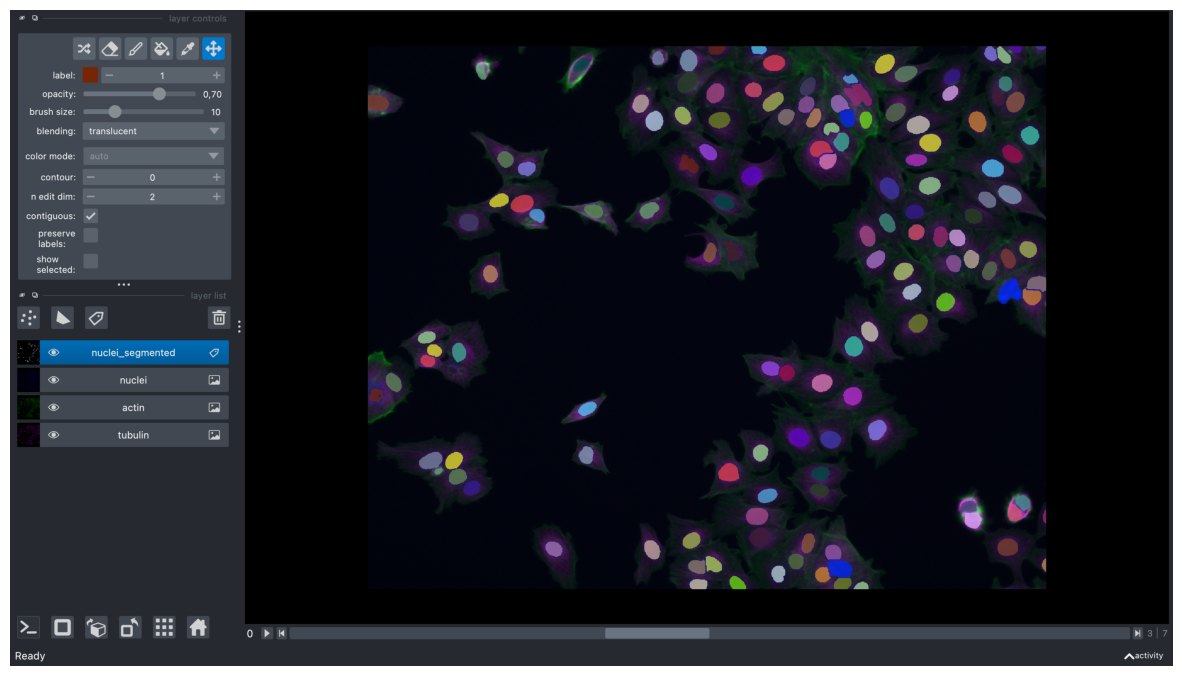

In [9]:
# note: some layers visibility and/or contrast limits were adjusted interactively in the viewer
screenshot = viewer.screenshot(canvas_only=False)

plt.figure(figsize=(15, 10))
plt.imshow(screenshot)
plt.axis('off')
plt.show()

In [9]:
save_path = os.path.join(path, "labels_nuclei")

if not os.path.exists(save_path):
    os.makedirs(save_path)

tif.imwrite(os.path.join(save_path, f'{filename}_labels_dapi.tif'), labels_timelapse)

### Process a batch of images from a folder

In [10]:
save_path = os.path.join(path, "labels_nuclei")

if not os.path.exists(save_path):
    os.makedirs(save_path)

for filename in tqdm(os.listdir(path)):
    
    if not filename.endswith("tif"):
        continue
        
    # print(f"Processing image {filename}")
    rgb_image = tif.imread(os.path.join(path, filename))
    
    # take the blue (DAPI) channel only
    img = rgb_image[:, :, :, 2]
    
    # initialize an empty list where we will put obtained label images
    labels = []
    
    # iterate though the "time" dimension of the image
    for t in range(img.shape[0]):

        # gaussian blur
        blurred_image = cle.gaussian_blur(img[t], None, 2.0, 2.0, 0.0)
        
        # remove background
        bg_removed = cle.top_hat_sphere(blurred_image, None, 20.0, 20.0, 0.0)

        # threshold otsu
        binary_nuclei = cle.threshold_otsu(bg_removed)

        # split touching objects
        binary_nuclei_edited = nsbatwm.split_touching_objects(binary_nuclei, 4.0)
        # additional erosion to split a few still touching nuclei
        binary_eroded_nuclei = binary_erosion(binary_nuclei_edited, disk(2))

        # connected component labeling
        labelled_nuclei = nsbatwm.connected_component_labeling(binary_eroded_nuclei, False)

        # expand eroded nuclei back
        dilated_labels = morphology.dilation(labelled_nuclei, disk(2))
        labels.append(dilated_labels)

    # we want to have only unique objects in each timepoint because it is not an actual timelapse!
    # adjusted_labels_array = adjust_labels(labels)
    
    # stack all obtained label images to a "timelapse"
    labels_timelapse = np.stack(labels, axis=0)
    
    # save the labels image
    tif.imwrite(os.path.join(save_path, filename.split(".tif")[0] + "_labels_dapi.tif"), labels_timelapse)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:40<00:00,  2.41s/it]
